# Glomeruli Segmentation 

Sources:  
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html  
https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae

### Import things

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import cv2
import tifffile as tiff
from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage  

import torch
import utils
import torchvision
import transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate

In [2]:
image_path = '../train/images/slices/'
images = os.listdir(image_path)

data_path = '../CSVs'
datafiles = os.listdir(data_path)

### Some functions

In [3]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
# This function loads the pretrained mask rcnn model

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
#Takes the coordinates from the glomeruli csv and turns them into bounding boxes
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
    "xmax", "ymax"]].values
   
    return boxes_array

### Make a Glomeruli class

In [6]:
class GlomeruliDataset(object):
    def __init__(self, root, data_file, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'train/images/slices'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'train/masks/slices'))))
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, 'train/images/slices', self.imgs[idx])
        mask_path = os.path.join(self.root, 'train/masks/slices', self.masks[idx])
        img = tiff.imread(img_path)
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(obj_ids)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# use our dataset and defined transformations
dataset = GlomeruliDataset('..', '../CSVs/glomeruli_tiles.csv', get_transform(train=True))
dataset_test = GlomeruliDataset('..', '../CSVs/glomeruli_tiles.csv', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, 
                                          num_workers=0,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, 
                                               num_workers=0,collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 1797 examples, 1597 are training and 200 testing


### Load the model

In [8]:
# our dataset has two classes only - background and glomeruli
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.01)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

### Training time!

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for ten epochs, printing every 100 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

C:\Users\lettuces\anaconda3\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [   0/1597]  eta: 0:39:49  lr: 0.000002  loss: 4.7235 (4.7235)  loss_classifier: 0.7590 (0.7590)  loss_box_reg: 0.0785 (0.0785)  loss_mask: 3.8399 (3.8399)  loss_objectness: 0.0415 (0.0415)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 1.4963  data: 0.0410  max mem: 1413
Epoch: [0]  [ 100/1597]  eta: 0:11:44  lr: 0.000102  loss: 0.8153 (1.8863)  loss_classifier: 0.1496 (0.2760)  loss_box_reg: 0.1455 (0.1188)  loss_mask: 0.3803 (1.2976)  loss_objectness: 0.0390 (0.1767)  loss_rpn_box_reg: 0.0049 (0.0172)  time: 0.4813  data: 0.0270  max mem: 1689
Epoch: [0]  [ 200/1597]  eta: 0:11:04  lr: 0.000202  loss: 0.6222 (1.3373)  loss_classifier: 0.1072 (0.2078)  loss_box_reg: 0.1230 (0.1340)  loss_mask: 0.2777 (0.8382)  loss_objectness: 0.0355 (0.1346)  loss_rpn_box_reg: 0.0032 (0.0227)  time: 0.4919  data: 0.0286  max mem: 1689
Epoch: [0]  [ 300/1597]  eta: 0:10:21  lr: 0.000302  loss: 0.5723 (1.0976)  loss_classifier: 0.0745 (0.1725)  loss_box_reg: 0.1586 (0.1454)  loss_mask: 0.1824 (

Epoch: [1]  [ 300/1597]  eta: 0:10:22  lr: 0.001000  loss: 0.4134 (0.4284)  loss_classifier: 0.0510 (0.0679)  loss_box_reg: 0.0719 (0.0917)  loss_mask: 0.2037 (0.2320)  loss_objectness: 0.0040 (0.0212)  loss_rpn_box_reg: 0.0021 (0.0155)  time: 0.4749  data: 0.0159  max mem: 1692
Epoch: [1]  [ 400/1597]  eta: 0:09:36  lr: 0.001000  loss: 0.4259 (0.4299)  loss_classifier: 0.0753 (0.0683)  loss_box_reg: 0.0894 (0.0921)  loss_mask: 0.2655 (0.2345)  loss_objectness: 0.0067 (0.0201)  loss_rpn_box_reg: 0.0035 (0.0150)  time: 0.4839  data: 0.0142  max mem: 1692
Epoch: [1]  [ 500/1597]  eta: 0:08:45  lr: 0.001000  loss: 0.2561 (0.4286)  loss_classifier: 0.0273 (0.0664)  loss_box_reg: 0.0490 (0.0898)  loss_mask: 0.1847 (0.2310)  loss_objectness: 0.0080 (0.0224)  loss_rpn_box_reg: 0.0022 (0.0190)  time: 0.4731  data: 0.0109  max mem: 1692
Epoch: [1]  [ 600/1597]  eta: 0:07:57  lr: 0.001000  loss: 0.3493 (0.4254)  loss_classifier: 0.0501 (0.0655)  loss_box_reg: 0.0726 (0.0889)  loss_mask: 0.2164 (

Epoch: [2]  [ 600/1597]  eta: 0:07:56  lr: 0.001000  loss: 0.2990 (0.4232)  loss_classifier: 0.0435 (0.0656)  loss_box_reg: 0.0712 (0.0891)  loss_mask: 0.1624 (0.2332)  loss_objectness: 0.0082 (0.0201)  loss_rpn_box_reg: 0.0021 (0.0152)  time: 0.4865  data: 0.0155  max mem: 1692
Epoch: [2]  [ 700/1597]  eta: 0:07:08  lr: 0.001000  loss: 0.3622 (0.4221)  loss_classifier: 0.0555 (0.0652)  loss_box_reg: 0.0886 (0.0883)  loss_mask: 0.2001 (0.2334)  loss_objectness: 0.0119 (0.0202)  loss_rpn_box_reg: 0.0030 (0.0150)  time: 0.4775  data: 0.0141  max mem: 1692
Epoch: [2]  [ 800/1597]  eta: 0:06:21  lr: 0.001000  loss: 0.4476 (0.4247)  loss_classifier: 0.0481 (0.0643)  loss_box_reg: 0.0886 (0.0883)  loss_mask: 0.1609 (0.2322)  loss_objectness: 0.0208 (0.0217)  loss_rpn_box_reg: 0.0028 (0.0182)  time: 0.4933  data: 0.0170  max mem: 1692
Epoch: [2]  [ 900/1597]  eta: 0:05:33  lr: 0.001000  loss: 0.2774 (0.4283)  loss_classifier: 0.0322 (0.0650)  loss_box_reg: 0.0509 (0.0886)  loss_mask: 0.1843 (

Epoch: [3]  [ 900/1597]  eta: 0:05:33  lr: 0.000100  loss: 0.2793 (0.3824)  loss_classifier: 0.0353 (0.0561)  loss_box_reg: 0.0413 (0.0820)  loss_mask: 0.1689 (0.2111)  loss_objectness: 0.0058 (0.0167)  loss_rpn_box_reg: 0.0021 (0.0165)  time: 0.4772  data: 0.0144  max mem: 1692
Epoch: [3]  [1000/1597]  eta: 0:04:46  lr: 0.000100  loss: 0.3364 (0.3796)  loss_classifier: 0.0367 (0.0563)  loss_box_reg: 0.0615 (0.0821)  loss_mask: 0.2039 (0.2085)  loss_objectness: 0.0084 (0.0169)  loss_rpn_box_reg: 0.0015 (0.0159)  time: 0.4886  data: 0.0138  max mem: 1692
Epoch: [3]  [1100/1597]  eta: 0:03:58  lr: 0.000100  loss: 0.2883 (0.3807)  loss_classifier: 0.0366 (0.0568)  loss_box_reg: 0.0461 (0.0827)  loss_mask: 0.1843 (0.2085)  loss_objectness: 0.0057 (0.0170)  loss_rpn_box_reg: 0.0017 (0.0157)  time: 0.4708  data: 0.0138  max mem: 1692
Epoch: [3]  [1200/1597]  eta: 0:03:10  lr: 0.000100  loss: 0.3218 (0.3816)  loss_classifier: 0.0388 (0.0570)  loss_box_reg: 0.0563 (0.0828)  loss_mask: 0.1883 (

Epoch: [4]  [1200/1597]  eta: 0:03:10  lr: 0.000100  loss: 0.3071 (0.3701)  loss_classifier: 0.0341 (0.0557)  loss_box_reg: 0.0510 (0.0825)  loss_mask: 0.1796 (0.2013)  loss_objectness: 0.0073 (0.0158)  loss_rpn_box_reg: 0.0012 (0.0149)  time: 0.4783  data: 0.0146  max mem: 1692
Epoch: [4]  [1300/1597]  eta: 0:02:23  lr: 0.000100  loss: 0.3224 (0.3701)  loss_classifier: 0.0336 (0.0557)  loss_box_reg: 0.0641 (0.0830)  loss_mask: 0.1562 (0.2002)  loss_objectness: 0.0079 (0.0158)  loss_rpn_box_reg: 0.0022 (0.0154)  time: 0.4712  data: 0.0169  max mem: 1692
Epoch: [4]  [1400/1597]  eta: 0:01:35  lr: 0.000100  loss: 0.2827 (0.3698)  loss_classifier: 0.0347 (0.0557)  loss_box_reg: 0.0764 (0.0832)  loss_mask: 0.1563 (0.1994)  loss_objectness: 0.0079 (0.0161)  loss_rpn_box_reg: 0.0016 (0.0155)  time: 0.4708  data: 0.0144  max mem: 1692
Epoch: [4]  [1500/1597]  eta: 0:00:46  lr: 0.000100  loss: 0.2505 (0.3677)  loss_classifier: 0.0378 (0.0556)  loss_box_reg: 0.0696 (0.0831)  loss_mask: 0.1274 (

Epoch: [5]  [1500/1597]  eta: 0:00:46  lr: 0.000100  loss: 0.3292 (0.3653)  loss_classifier: 0.0354 (0.0559)  loss_box_reg: 0.0686 (0.0826)  loss_mask: 0.1731 (0.1977)  loss_objectness: 0.0068 (0.0148)  loss_rpn_box_reg: 0.0018 (0.0143)  time: 0.4896  data: 0.0137  max mem: 1692
Epoch: [5]  [1596/1597]  eta: 0:00:00  lr: 0.000100  loss: 0.1803 (0.3641)  loss_classifier: 0.0253 (0.0555)  loss_box_reg: 0.0375 (0.0823)  loss_mask: 0.1250 (0.1972)  loss_objectness: 0.0035 (0.0147)  loss_rpn_box_reg: 0.0021 (0.0144)  time: 0.4546  data: 0.0145  max mem: 1692
Epoch: [5] Total time: 0:12:46 (0.4799 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:00:46  model_time: 0.2001 (0.2001)  evaluator_time: 0.0030 (0.0030)  time: 0.2300  data: 0.0110  max mem: 1692
Test:  [100/200]  eta: 0:00:19  model_time: 0.1766 (0.1789)  evaluator_time: 0.0060 (0.0063)  time: 0.2016  data: 0.0125  max mem: 1692
Test:  [199/200]  eta: 0:00:00  model_time: 0.1686 (0.1791)  evaluator_time: 0.0060 (0.0

Test:  [100/200]  eta: 0:00:19  model_time: 0.1785 (0.1790)  evaluator_time: 0.0059 (0.0064)  time: 0.2031  data: 0.0124  max mem: 1692
Test:  [199/200]  eta: 0:00:00  model_time: 0.1676 (0.1795)  evaluator_time: 0.0060 (0.0066)  time: 0.1980  data: 0.0125  max mem: 1692
Test: Total time: 0:00:39 (0.1994 s / it)
('Averaged stats:', <utils.MetricLogger object at 0x000001C8828010D0>)
Accumulating evaluation results...
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.706
 Average Recall 

Epoch: [8]  [   0/1597]  eta: 0:12:14  lr: 0.000010  loss: 0.5961 (0.5961)  loss_classifier: 0.0630 (0.0630)  loss_box_reg: 0.0534 (0.0534)  loss_mask: 0.4265 (0.4265)  loss_objectness: 0.0315 (0.0315)  loss_rpn_box_reg: 0.0217 (0.0217)  time: 0.4599  data: 0.0120  max mem: 1692
Epoch: [8]  [ 100/1597]  eta: 0:11:55  lr: 0.000010  loss: 0.3041 (0.3313)  loss_classifier: 0.0412 (0.0529)  loss_box_reg: 0.0712 (0.0770)  loss_mask: 0.1867 (0.1835)  loss_objectness: 0.0052 (0.0109)  loss_rpn_box_reg: 0.0037 (0.0070)  time: 0.4835  data: 0.0149  max mem: 1692
Epoch: [8]  [ 200/1597]  eta: 0:11:12  lr: 0.000010  loss: 0.4378 (0.3513)  loss_classifier: 0.0415 (0.0543)  loss_box_reg: 0.0916 (0.0803)  loss_mask: 0.1937 (0.1906)  loss_objectness: 0.0067 (0.0128)  loss_rpn_box_reg: 0.0036 (0.0134)  time: 0.4782  data: 0.0148  max mem: 1692
Epoch: [8]  [ 300/1597]  eta: 0:10:23  lr: 0.000010  loss: 0.2645 (0.3401)  loss_classifier: 0.0284 (0.0517)  loss_box_reg: 0.0511 (0.0778)  loss_mask: 0.1695 (

Epoch: [9]  [ 300/1597]  eta: 0:10:26  lr: 0.000001  loss: 0.3073 (0.3547)  loss_classifier: 0.0536 (0.0543)  loss_box_reg: 0.0794 (0.0796)  loss_mask: 0.1658 (0.1952)  loss_objectness: 0.0072 (0.0128)  loss_rpn_box_reg: 0.0017 (0.0127)  time: 0.4935  data: 0.0157  max mem: 1692
Epoch: [9]  [ 400/1597]  eta: 0:09:36  lr: 0.000001  loss: 0.2597 (0.3501)  loss_classifier: 0.0350 (0.0535)  loss_box_reg: 0.0415 (0.0773)  loss_mask: 0.1301 (0.1924)  loss_objectness: 0.0033 (0.0129)  loss_rpn_box_reg: 0.0014 (0.0141)  time: 0.4840  data: 0.0142  max mem: 1692
Epoch: [9]  [ 500/1597]  eta: 0:08:48  lr: 0.000001  loss: 0.3369 (0.3462)  loss_classifier: 0.0515 (0.0534)  loss_box_reg: 0.0595 (0.0779)  loss_mask: 0.1651 (0.1901)  loss_objectness: 0.0052 (0.0124)  loss_rpn_box_reg: 0.0020 (0.0124)  time: 0.4919  data: 0.0154  max mem: 1692
Epoch: [9]  [ 600/1597]  eta: 0:07:59  lr: 0.000001  loss: 0.2356 (0.3482)  loss_classifier: 0.0295 (0.0528)  loss_box_reg: 0.0553 (0.0779)  loss_mask: 0.1477 (

### Save the model

In [10]:
# make a folder for the model to live in
try:
    os.mkdir("../model")
except FileExistsError:
    pass

In [11]:
torch.save(model.state_dict(), "../model/glomeruli_segmentation_model")

### Visualize the predictions

In [12]:
# load the model that we just made
loaded_model = get_model_instance_segmentation(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/glomeruli_segmentation_model"))

<All keys matched successfully>

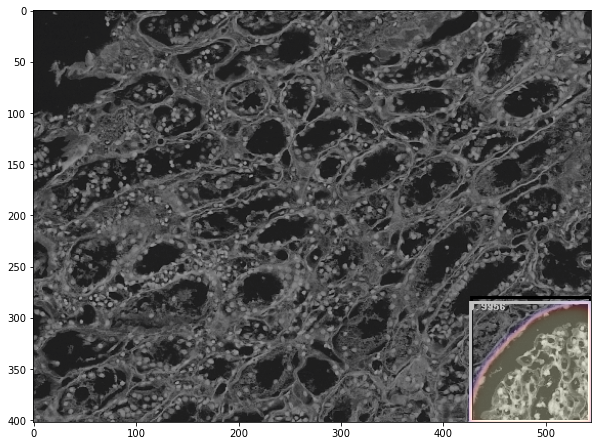

In [14]:
idx = 111
# pick one image from the test set
img = dataset_test[idx][0]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# put the model in evaluation model
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])
    
draw = ImageDraw.Draw(image)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="black", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    
    mask = prediction[0]['masks'][element,0].cpu().numpy()
    if score > 0.8:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
                        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score), fill=255)
        plt.figure(figsize=[10,10])
        plt.imshow(image,cmap='gray')
        plt.imshow(mask, cmap='magma', alpha=0.25)

### Make a test class

In [15]:
class TestingDataset(object):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'test/images/slices')))
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'test/images/slices', self.imgs[idx])
        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
        
        # there is only one class
        image_id = torch.tensor([idx])
        imgid = self.imgs[idx]
        target = {}
        if self.transforms is not None:
            img = self.transforms(img, target)
        return img, imgid
    def __len__(self):
        return len(self.imgs)

### Load the model

In [16]:
loaded_model = get_model_instance_segmentation(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/glomeruli_segmentation_model"))

<All keys matched successfully>

In [17]:
testset = TestingDataset(root = '..', 
                         transforms = get_transform(train=False))

### Visualize test prediction results

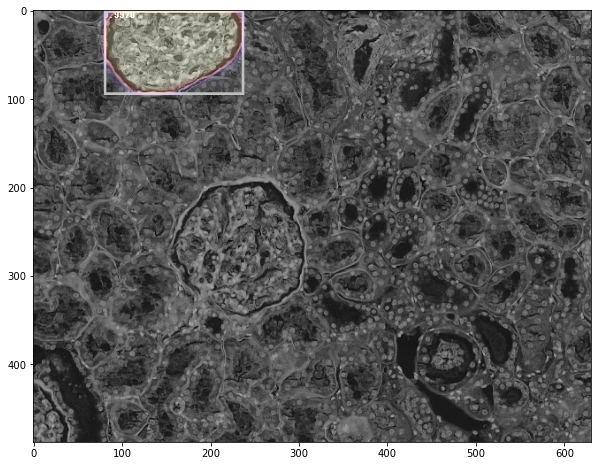

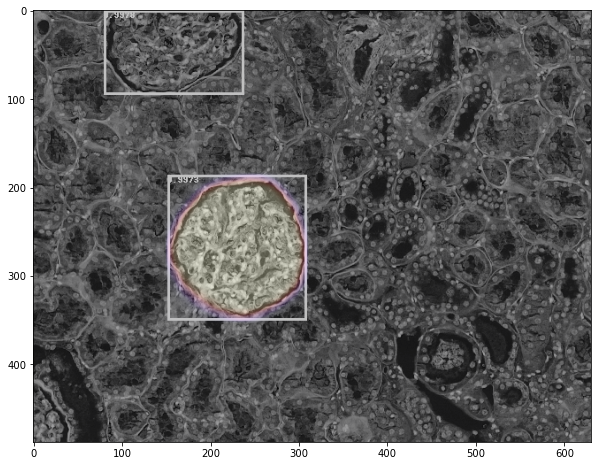

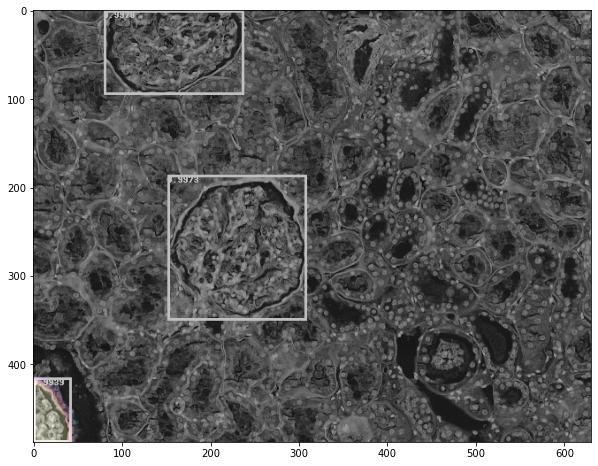

In [18]:
if torch.cuda.is_available():
        loaded_model.cuda()
idx = 2635
# pick one image from the test set
tensor_img = testset[idx][0][0][None, :,:].to(device)
img = testset[idx][0][0]

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# put the model in evaluation model
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model(tensor_img)
    
draw = ImageDraw.Draw(image)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    
    mask = prediction[0]['masks'][element,0].cpu().numpy()
    if score > 0.8:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
                        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score), fill=255)
        plt.figure(figsize=[10,10])
        plt.imshow(image,cmap='gray')
        plt.imshow(mask, cmap='magma', alpha=0.25)

### Save the predictions as a CSV file

In [19]:
def make_predictions(first_number, second_number):
    predictions = []
    
    if torch.cuda.is_available():
        loaded_model.cuda()

    #Set model to evaluation mode
    loaded_model.eval()
    for i in range(first_number, second_number):
        tensor_img = testset[i][0][0][None, :,:].to(device)
        scores_masks_dict = {}
        with torch.no_grad():
            preds = loaded_model(tensor_img)
            
            for element in range(len(preds[0]["boxes"])):
                scores_masks_dict = {}
                
                score = np.round(preds[0]["scores"][element].cpu().numpy(),
                                 decimals= 4)
                filename = testset.imgs[i]
                mask = preds[0]['masks'][element, 0].cpu().numpy().astype(int)
                
                if score > 0.8:
                    scores_masks_dict['scores'] = score
                    scores_masks_dict['masks'] = mask
                    scores_masks_dict['filename'] = filename
                    predictions.append(scores_masks_dict)
    return predictions

In [20]:
pred_list = make_predictions(0, 3812)

In [63]:
test_preds = pd.DataFrame(pred_list)

In [65]:
test_preds['masks'] = test_preds['masks'].map(lambda x: tuple(x)) #it has to be in a tuple to be saved as an array

In [66]:
test_preds.to_csv('../CSVs/mask_rcnn_preds.csv', index=False)

In [67]:
test_preds = pd.read_csv('../CSVs/mask_rcnn_preds.csv')
test_preds.head()

,scores,masks,filename
0,0.9797,"(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26dc41664_10132_13220.tiff
1,0.9960,"(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26dc41664_10132_13881.tiff
2,0.9938,"(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26dc41664_10132_13881.tiff
3,0.8841,"(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26dc41664_10132_13881.tiff
4,0.9881,"(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26dc41664_10132_14542.tiff
